In [1]:
import plotting
import importlib
importlib.reload(plotting)
import numpy as np
import transforms
import sampling
import matplotlib.pyplot as plt
import sys
import scipy
#np.set_printoptions(suppress=True)
import chernoff
from tqdm import tqdm
np.set_printoptions(threshold=sys.maxsize)
import methods
import prop
importlib.reload(prop)
import pipeline
importlib.reload(pipeline)
import chernoff
importlib.reload(chernoff)
import matplotlib as mpl
import spectral_clusterings
importlib.reload(spectral_clusterings)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'DejaVu Serif'
mpl.rcParams["mathtext.default"] = 'rm'
mpl.rcParams["mathtext.fontset"]= 'dejavuserif'

In [2]:
ga,gb = 1,0.5
#for ga in [0.5, 0.8, 1]:
#    for gb in [0.1, 0.2, 0.3, 0.5, 0.8, 1, 1.5, 2]:
for gb in np.arange(0.1, 2, 0.1):
    print(gb,np.mean(sampling.truncated_sample(scipy.stats.gamma, [ga,0,1/gb], 1, 100_000)))

0.1 0.4903525409873937
0.2 0.4827205049812066
0.30000000000000004 0.47305486813125824
0.4 0.46612509281734127
0.5 0.45848479724286473
0.6 0.45056832769890287
0.7000000000000001 0.44276917013450623
0.8 0.43523646162039964
0.9 0.4265783287492385
1.0 0.41848639890979517
1.1 0.4099558434726723
1.2000000000000002 0.4036282896500703
1.3000000000000003 0.3944743106988177
1.4000000000000001 0.38757651105351265
1.5000000000000002 0.37912893492269856
1.6 0.3721517239312121
1.7000000000000002 0.36535883196948954
1.8000000000000003 0.358187669986248
1.9000000000000001 0.3494312407599421


In [3]:
def identity_transform(X):
    return np.copy(X)

def log_transform(X):
    X = np.copy(X)
    X[X == 0.999] = 1
    return np.log(X)

def stouffer_transform(X):
    X = X/1.01
    res = scipy.stats.norm.ppf(X)
    res[res == scipy.stats.norm.ppf(0.999/1.01)] = 0
    return res

def george_transform(X):
    X = X/1.01
    res = np.log(X) - np.log(1 - X)
    badx = 0.999/1.01
    res[res == np.log(badx/(1-badx))] = 0
    return res

def log_likelihood(X):
    trunc = scipy.stats.gamma.cdf(1, ga,0,1/gb) - scipy.stats.gamma.cdf(0, ga,0,1/gb)
    res = scipy.stats.gamma.pdf(X, ga,0,1/gb)/trunc
    res[res == scipy.stats.gamma.pdf(0.999, ga,0,1/gb)] = 1
    return np.log(res)

def threshold_001(X):
    succ = X < 0.01
    R = np.zeros(X.shape)
    R[succ] = 1
    return R

def threshold_005(X):
    succ = X < 0.05
    R = np.zeros(X.shape)
    R[succ] = 1
    return R

def threshold_010(X):
    succ = X < 0.1
    R = np.zeros(X.shape)
    R[succ] = 1
    return R

TRANSFORMS = [
    [log_likelihood, "Log-Likelihood"],
    (log_transform, "Fisher"),
    (george_transform, "George"),
    (stouffer_transform, "Stouffer"),
    (identity_transform, "Identity"),
    (threshold_005, "0.01 Threshold"),
    (threshold_005, "0.05 Threshold"),
    (threshold_010, "0.10 Threshold"),
]

  4%|▍         | 2/51 [00:00<00:04, 11.34it/s]

100%|██████████| 51/51 [00:04<00:00, 10.86it/s]


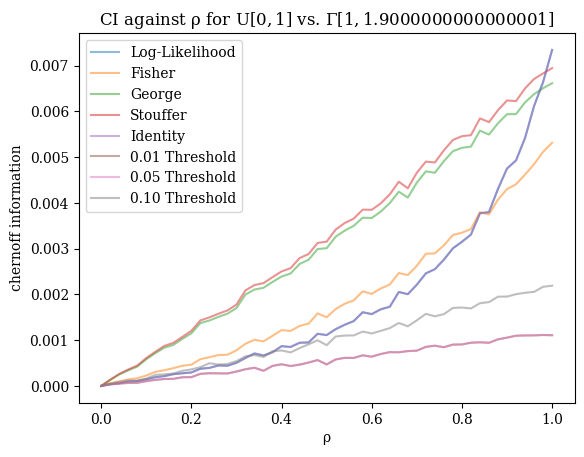

In [4]:
pi = 0.2
gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [ga,0,1/gb])
model = sampling.WSBM(f"$\\Gamma[{ga},{gb}]$", gamma_dists, gamma_params, np.array([pi,1 - pi]))
chernoff.plot_transforms_new(model, TRANSFORMS)

In [5]:
l = [3,6,2,7]
ll = [(y,x) for x,y in enumerate(l)]
list(sorted(ll))

[(2, 2), (3, 0), (6, 1), (7, 3)]

In [6]:
import pickle

In [7]:
list(sorted([4,6,5]))

[4, 5, 6]

In [172]:
def pred_from_prior(p,gt,pi):
    N = len(p)
    if np.logical_or(p == 0,p == 1).all():
        #if sum(p) > N / 2: return 1 - p
        overlap = sum([1 if gg == pp else 0 for gg,pp in zip(gt,p)])
        if overlap < N / 2: return 1 - p
        else: return p

    ll = list(sorted([(y,x) for x,y in enumerate(p)]))[::-1]
    r = np.zeros(N)
    good = sum([gt[x] for _,x in ll[:50]])
    if good < 25:
        ll = ll[::-1]
    r[[x for _,x in ll[:int(N * pi)]]] = 1
    return r

def hellinger(p,gt):
    #return np.sum(np.abs(p-gt))
    ip,igt = 1-p, 1-gt
    inner,inneri = np.sqrt(p) - gt, np.sqrt(ip) - igt
    return 1/np.sqrt(2) * np.sum(np.sqrt(inner * inner + inneri * inneri))
    assert(p >= 0).all()
    inner = np.sqrt(p) - np.sqrt(gt)
    return (1/np.sqrt(2)) * np.sqrt(np.sum(inner * inner))
        

def plot_accuracy_mean(algorithms, gran = 30):
    a = 1
    n = 10
    N = 1000
    rho = 1
    pi = 0.2

    vals = np.arange(0.1, 2.6, 2.5/gran)
    hells = np.zeros((len(vals), len(algorithms), n))
    accuracies = np.zeros((len(vals), len(algorithms), n))
    mu_1s = []
    for j,b in enumerate(tqdm(vals)): 
        gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [a,0,1/b])
        model = sampling.WSBM(f"$\\Gamma[{a},{b}]$", gamma_dists, gamma_params, np.array([pi,1 - pi]))
        mu_1s.append(np.mean(sampling.truncated_sample(scipy.stats.gamma, [a,0,1/b], 1, 1_000_000)))

        for fold in range(n):
            local_graph = model.sample(N, rho)
            uperm,perm = local_graph.permute(False, True)
            gt = np.concatenate((np.ones(int(N*pi)), np.zeros(N-int(N*pi))))[perm]
            embedded = spectral_clusterings.spectral(local_graph.graph)
            for i,algorithm in enumerate(algorithms):
                p = np.array(algorithm[0](embedded))
                #pred = pred_from_prior(p, gt, 0.15)
                #overlap = sum([1 if gg == pp else 0 for gg,pp in zip(gt,pred)])
                if algorithm[1] == "GMM":
                    psamp = [1 if k > 1 else 0 for k in p[:25]]
                    overlap = sum([1 if gg == pp else 0 for gg,pp in zip(gt[:25],psamp)])
                    if overlap < 13:
                        # H0/H1
                        r_ = p * (1-pi)/pi
                        p = 1/(r_ + 1)
                    else:
                        #H1/H0
                        r_ = p * pi/(1-pi)
                        p = r_/(1 + r_)
                elif algorithm[1] == "K-Means":
                    psamp = [1 if k > 1 else 0 for k in p[:50]]
                    overlap = sum([1 if gg == pp else 0 for gg,pp in zip(gt[:50],psamp)])
                    if overlap < 25:
                        p = 1 - p
                elif algorithm[1] == "Direct eigenvector":
                    nanom = int(N * pi)
                    #print (nanom, p.shape)
                    idxs = np.argpartition(p, -nanom)[-nanom:]
                    overlap = sum(gt[idxs[:25]])
                    if overlap < 13:
                        idxs = np.argpartition(p, nanom)[:nanom]
                    p_ = np.zeros(N)
                    p_[idxs] = 1
                    p = p_
                
                pred = pred_from_prior(p, gt, pi)
                overlap = sum([1 if gg == pp else 0 for gg,pp in zip(gt,pred)])
                hells[j][i][fold] = hellinger(np.array(p),gt)#overlap/N
                accuracies[j][i][fold] = overlap/N
                #print (p, np.sqrt(p))
    acc_mean = np.mean(accuracies, axis = 2)
    acc_std = np.std(accuracies, axis = 2)
    hell_mean = np.mean(hells, axis = 2)
    hell_std = np.std(hells, axis = 2)

    for i in range(len(algorithms)):
        stds = acc_std[:, i]
        yerr = [stds, stds]

        plt.errorbar(mu_1s, acc_mean[:, i], yerr=yerr, capsize=3, fmt="--o", label=algorithms[i][1])
    plt.legend()
    plt.show()

    for i in range(len(algorithms)):
        stds = hell_std[:, i]
        yerr = [stds, stds]

        plt.errorbar(mu_1s, hell_mean[:, i], yerr=yerr, capsize=3, fmt="--o", label=algorithms[i][1])
    plt.legend()
    plt.show()
    return acc_mean, acc_std, hell_mean, hell_std

ALGORITHMS = [
    (spectral_clusterings.trivial_clustering, "Direct eigenvector"),
    (spectral_clusterings.GMM_clustering, "GMM"),
    (spectral_clusterings.KMeans_clustering, "K-Means"),
    ((lambda x : spectral_clusterings.SP_clustering(x, 0.2)), "SP-cluster")
]

RES_GAMMA_VARYING_MEAN = plot_accuracy_mean(ALGORITHMS, 20)
with open("RES_GAMMA_VARYING_MEAN.pkl", "wb") as f:
    pickle.dump(RES_GAMMA_VARYING_MEAN,f)

  0%|          | 0/20 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [13]:
2 * 0.2 * 0.8

0.32000000000000006

100%|██████████| 15/15 [09:22<00:00, 37.48s/it]


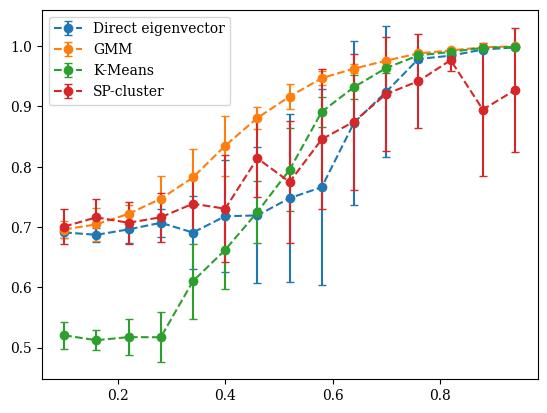

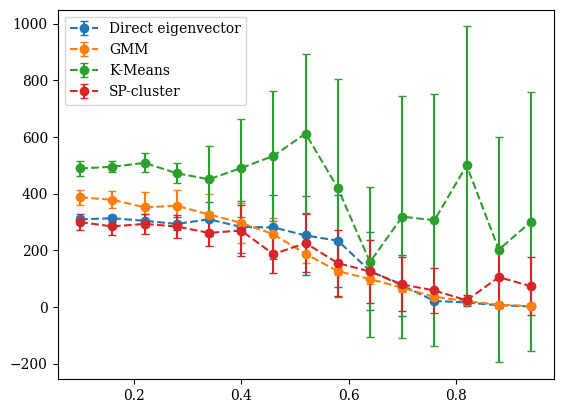

In [9]:

def plot_accuracy_rho(algorithms, gran = 30):
    a = 1
    b = 1.5
    n = 10
    N = 1000
    pi = 0.2

    vals = np.arange(0.1, 1, 0.9/gran)
    hells = np.zeros((len(vals), len(algorithms), n))
    accuracies = np.zeros((len(vals), len(algorithms), n))
    mu_1s = []
    for j,rho in enumerate(tqdm(vals)): 
        gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [a,0,1/b])
        model = sampling.WSBM(f"$\\Gamma[{a},{b}]$", gamma_dists, gamma_params, np.array([pi,1 - pi]))
        mu_1s.append(np.mean(sampling.truncated_sample(scipy.stats.gamma, [a,0,1/b], 1, 1_000_000)))

        for fold in range(n):
            local_graph = model.sample(N, rho)
            uperm,perm = local_graph.permute(False, True)
            gt = np.concatenate((np.ones(int(N*pi)), np.zeros(N-int(N*pi))))[perm]
            embedded = spectral_clusterings.spectral(local_graph.graph)
            for i,algorithm in enumerate(algorithms):
                p = np.array(algorithm[0](embedded))
                #pred = pred_from_prior(p, gt, 0.15)
                #overlap = sum([1 if gg == pp else 0 for gg,pp in zip(gt,pred)])
                if algorithm[1] == "GMM":
                    psamp = [1 if k > 1 else 0 for k in p[:25]]
                    overlap = sum([1 if gg == pp else 0 for gg,pp in zip(gt[:25],psamp)])
                    if overlap < 13:
                        # H0/H1
                        r_ = p * (1-pi)/pi
                        p = 1/(r_ + 1)
                    else:
                        #H1/H0
                        r_ = p * pi/(1-pi)
                        p = r_/(1 + r_)
                elif algorithm[1] == "K-Means":
                    psamp = [1 if k > 1 else 0 for k in p[:50]]
                    overlap = sum([1 if gg == pp else 0 for gg,pp in zip(gt[:50],psamp)])
                    if overlap < 25:
                        p = 1 - p
                elif algorithm[1] == "Direct eigenvector":
                    nanom = int(N * pi)
                    #print (nanom, p.shape)
                    idxs = np.argpartition(p, -nanom)[-nanom:]
                    overlap = sum(gt[idxs[:25]])
                    if overlap < 13:
                        idxs = np.argpartition(p, nanom)[:nanom]
                    p_ = np.zeros(N)
                    p_[idxs] = 1
                    p = p_
                
                pred = pred_from_prior(p, gt, pi)
                overlap = sum([1 if gg == pp else 0 for gg,pp in zip(gt,pred)])
                hells[j][i][fold] = hellinger(np.array(p),gt)#overlap/N
                accuracies[j][i][fold] = overlap/N
                #print (p, np.sqrt(p))
    acc_mean = np.mean(accuracies, axis = 2)
    acc_std = np.std(accuracies, axis = 2)
    hell_mean = np.mean(hells, axis = 2)
    hell_std = np.std(hells, axis = 2)

    for i in range(len(algorithms)):
        stds = acc_std[:, i]
        yerr = [stds, stds]

        plt.errorbar(vals, acc_mean[:, i], yerr=yerr, capsize=3, fmt="--o", label=algorithms[i][1])
    plt.legend()
    plt.show()

    for i in range(len(algorithms)):
        stds = hell_std[:, i]
        yerr = [stds, stds]

        plt.errorbar(vals, hell_mean[:, i], yerr=yerr, capsize=3, fmt="--o", label=algorithms[i][1])
    plt.legend()
    plt.show()
    return acc_mean, acc_std, hell_mean, hell_std

ALGORITHMS = [
    (spectral_clusterings.trivial_clustering, "Direct eigenvector"),
    (spectral_clusterings.GMM_clustering, "GMM"),
    (spectral_clusterings.KMeans_clustering, "K-Means"),
    ((lambda x : spectral_clusterings.SP_clustering(x, 0.2)), "SP-cluster")
]

RES_GAMMA_VARYING_RHO = plot_accuracy_rho(ALGORITHMS, 15)
with open("RES_GAMMA_VARYING_RHO.pkl", "wb") as f:
    pickle.dump(RES_GAMMA_VARYING_RHO,f)

100%|██████████| 2/2 [20:18<00:00, 609.35s/it]


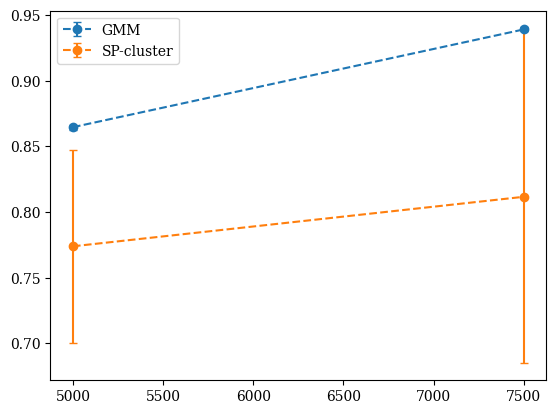

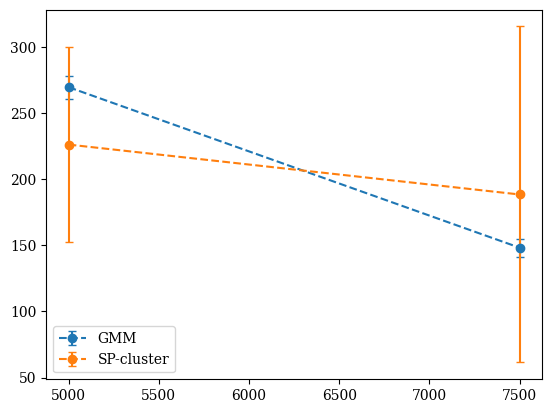

In [176]:

def plot_accuracy_N(algorithms, gran = 30):
    algorithms = [algorithms[1],algorithms[3]]
    a = 1
    b = 1.5
    n = 2
    pi = 0.2
    rho = 0.2

    vals = [5000, 7500]
    hells = np.zeros((len(vals), len(algorithms), n))
    accuracies = np.zeros((len(vals), len(algorithms), n))
    mu_1s = []
    for j,N in enumerate(tqdm(vals)): 
        gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [a,0,1/b])
        model = sampling.WSBM(f"$\\Gamma[{a},{b}]$", gamma_dists, gamma_params, np.array([pi,1 - pi]))
        mu_1s.append(np.mean(sampling.truncated_sample(scipy.stats.gamma, [a,0,1/b], 1, 1_000_000)))

        for fold in range(n):
            local_graph = model.sample(N, rho)
            uperm,perm = local_graph.permute(False, True)
            gt = np.concatenate((np.ones(int(N*pi)), np.zeros(N-int(N*pi))))[perm]
            embedded = spectral_clusterings.spectral(local_graph.graph)
            for i,algorithm in enumerate(algorithms):
                p = np.array(algorithm[0](embedded))
                #pred = pred_from_prior(p, gt, 0.15)
                #overlap = sum([1 if gg == pp else 0 for gg,pp in zip(gt,pred)])
                if algorithm[1] == "GMM":
                    psamp = [1 if k > 1 else 0 for k in p[:25]]
                    overlap = sum([1 if gg == pp else 0 for gg,pp in zip(gt[:25],psamp)])
                    if overlap < 13:
                        # H0/H1
                        r_ = p * (1-pi)/pi
                        p = 1/(r_ + 1)
                    else:
                        #H1/H0
                        r_ = p * pi/(1-pi)
                        p = r_/(1 + r_)
                elif algorithm[1] == "K-Means":
                    psamp = [1 if k > 1 else 0 for k in p[:50]]
                    overlap = sum([1 if gg == pp else 0 for gg,pp in zip(gt[:50],psamp)])
                    if overlap < 25:
                        p = 1 - p
                elif algorithm[1] == "Direct eigenvector":
                    nanom = int(N * pi)
                    #print (nanom, p.shape)
                    idxs = np.argpartition(p, -nanom)[-nanom:]
                    overlap = sum(gt[idxs[:25]])
                    if overlap < 13:
                        idxs = np.argpartition(p, nanom)[:nanom]
                    p_ = np.zeros(N)
                    p_[idxs] = 1
                    p = p_
                
                pred = pred_from_prior(p, gt, pi)
                overlap = sum([1 if gg == pp else 0 for gg,pp in zip(gt,pred)])
                hells[j][i][fold] = (hellinger(np.array(p),gt)/N)*1000#overlap/N
                accuracies[j][i][fold] = overlap/N
                #print (p, np.sqrt(p))
    acc_mean = np.mean(accuracies, axis = 2)
    acc_std = np.std(accuracies, axis = 2)
    hell_mean = np.mean(hells, axis = 2)
    hell_std = np.std(hells, axis = 2)

    for i in range(len(algorithms)):
        stds = acc_std[:, i]
        yerr = [stds, stds]

        plt.errorbar(vals, acc_mean[:, i], yerr=yerr, capsize=3, fmt="--o", label=algorithms[i][1])
    plt.legend()
    plt.show()

    for i in range(len(algorithms)):
        stds = hell_std[:, i]
        yerr = [stds, stds]

        plt.errorbar(vals, hell_mean[:, i], yerr=yerr, capsize=3, fmt="--o", label=algorithms[i][1])
    plt.legend()
    plt.show()
    return acc_mean, acc_std, hell_mean, hell_std

ALGORITHMS = [
    (spectral_clusterings.trivial_clustering, "Direct eigenvector"),
    (spectral_clusterings.GMM_clustering, "GMM"),
    (spectral_clusterings.KMeans_clustering, "K-Means"),
    ((lambda x : spectral_clusterings.SP_clustering(x, 0.2)), "SP-cluster")
]

RES_GAMMA_VARYING_N = plot_accuracy_N(ALGORITHMS, 15)
with open("RES_GAMMA_VARYING_N__.pkl", "wb") as f:
    pickle.dump(RES_GAMMA_VARYING_N,f)

100%|██████████| 10/10 [05:44<00:00, 34.46s/it]


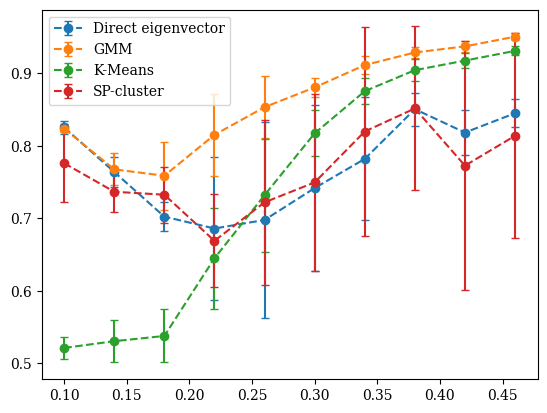

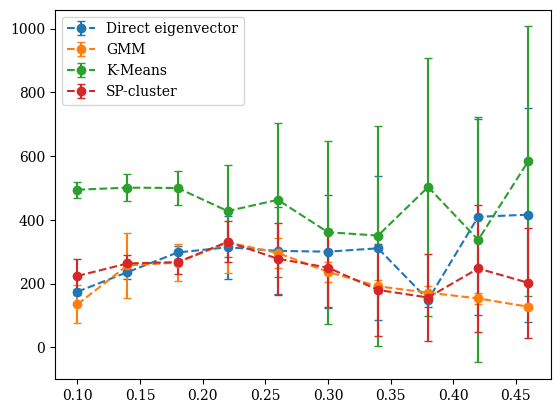

In [173]:
importlib.reload(sampling)
        

def plot_accuracy_pi(algorithms, gran = 30):
    a = 1
    b = 1.5
    n = 10
    N = 1000
    rho = 0.5

    vals = np.arange(0.1, 0.5, 0.4/gran)
    hells = np.zeros((len(vals), len(algorithms), n))
    accuracies = np.zeros((len(vals), len(algorithms), n))
    mu_1s = []
    for j,pi in enumerate(tqdm(vals)): 
        gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [a,0,1/b])
        model = sampling.WSBM(f"$\\Gamma[{a},{b}]$", gamma_dists, gamma_params, np.array([pi,1 - pi]))
        mu_1s.append(np.mean(sampling.truncated_sample(scipy.stats.gamma, [a,0,1/b], 1, 1_000_000)))

        for fold in range(n):
            local_graph = model.sample(N, rho)
            uperm,perm = local_graph.permute(False, True)
            #print (local_graph.graph.shape)
            nanom = int(N * pi)
            gt = np.zeros(N)
            gt[:nanom] = 1
            gt = gt[perm]
            embedded = spectral_clusterings.spectral(local_graph.graph)
            for i,algorithm in enumerate(algorithms):
                if algorithm[1] == "SP-cluster":
                    p = np.array(algorithm[0](embedded,pi))
                else:
                    p = np.array(algorithm[0](embedded))

                #pred = pred_from_prior(p, gt, 0.15)
                #overlap = sum([1 if gg == pp else 0 for gg,pp in zip(gt,pred)])
                if algorithm[1] == "GMM":
                    psamp = [1 if k > 1 else 0 for k in p[:25]]
                    overlap = sum([1 if gg == pp else 0 for gg,pp in zip(gt[:25],psamp)])
                    if overlap < 13:
                        # H0/H1
                        r_ = p * (1-pi)/pi
                        p = 1/(r_ + 1)
                    else:
                        #H1/H0
                        r_ = p * pi/(1-pi)
                        p = r_/(1 + r_)
                elif algorithm[1] == "K-Means":
                    psamp = [1 if k > 1 else 0 for k in p[:50]]
                    overlap = sum([1 if gg == pp else 0 for gg,pp in zip(gt[:50],psamp)])
                    if overlap < 25:
                        p = 1 - p
                elif algorithm[1] == "Direct eigenvector":
                    nanom = int(N * pi)
                    #print (nanom, p.shape)
                    idxs = np.argpartition(p, -nanom)[-nanom:]
                    overlap = sum(gt[idxs[:25]])
                    if overlap < 13:
                        idxs = np.argpartition(p, nanom)[:nanom]
                    p_ = np.zeros(N)
                    p_[idxs] = 1
                    p = p_
                
                pred = pred_from_prior(p, gt, pi)
                overlap = sum([1 if gg == pp else 0 for gg,pp in zip(gt,pred)])
                hells[j][i][fold] = hellinger(np.array(p),gt)#overlap/N
                accuracies[j][i][fold] = overlap/N
                #print (p, np.sqrt(p))
    acc_mean = np.mean(accuracies, axis = 2)
    acc_std = np.std(accuracies, axis = 2)
    hell_mean = np.mean(hells, axis = 2)
    hell_std = np.std(hells, axis = 2)

    for i in range(len(algorithms)):
        stds = acc_std[:, i]
        yerr = [stds, stds]

        plt.errorbar(vals, acc_mean[:, i], yerr=yerr, capsize=3, fmt="--o", label=algorithms[i][1])
    plt.legend()
    plt.show()

    for i in range(len(algorithms)):
        stds = hell_std[:, i]
        yerr = [stds, stds]

        plt.errorbar(vals, hell_mean[:, i], yerr=yerr, capsize=3, fmt="--o", label=algorithms[i][1])
    plt.legend()
    plt.show()
    return acc_mean, acc_std, hell_mean, hell_std

ALGORITHMS = [
    (spectral_clusterings.trivial_clustering, "Direct eigenvector"),
    (spectral_clusterings.GMM_clustering, "GMM"),
    (spectral_clusterings.KMeans_clustering, "K-Means"),
    (spectral_clusterings.SP_clustering, "SP-cluster")
]

RES_GAMMA_VARYING_PI = plot_accuracy_pi(ALGORITHMS, 10)
with open("RES_GAMMA_VARYING_PI.pkl", "wb") as f:
    pickle.dump(RES_GAMMA_VARYING_PI,f)

100%|██████████| 20/20 [00:01<00:00, 10.95it/s]


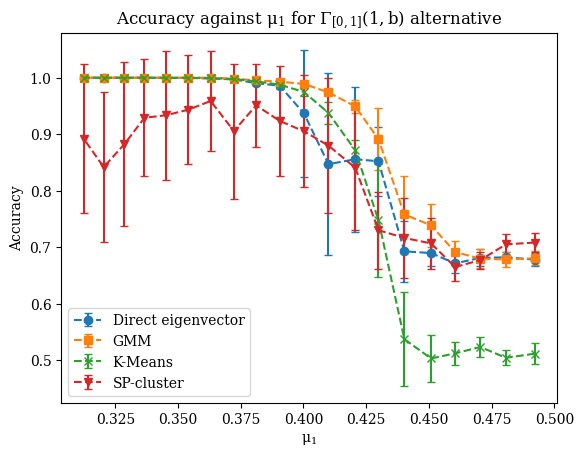

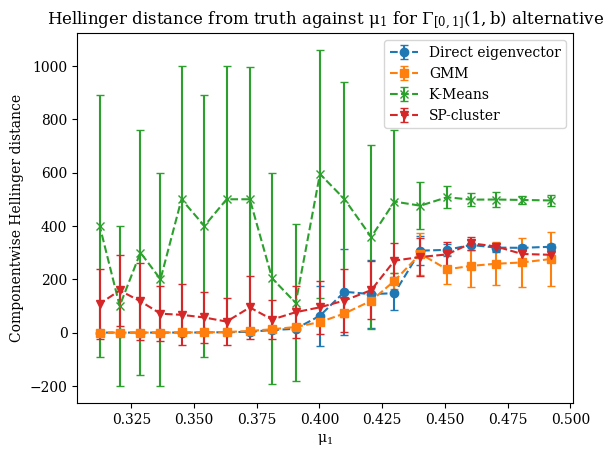

In [39]:
with open("RES_GAMMA_VARYING_MEAN.pkl", "rb") as f:
    RES_GAMMA_VARYING_MEAN=pickle.load(f)
    
vals = vals = np.arange(0.1, 2.6, 2.5/20)
a = 1
mu_1s = []
for j,b in enumerate(tqdm(vals)): 
    gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [a,0,1/b])
    model = sampling.WSBM(f"$\\Gamma[{a},{b}]$", gamma_dists, gamma_params, np.array([pi,1 - pi]))
    mu_1s.append(np.mean(sampling.truncated_sample(scipy.stats.gamma, [a,0,1/b], 1, 1_000_000)))
acc_mean, acc_std, hell_mean, hell_std = RES_GAMMA_VARYING_MEAN

for i in range(len(ALGORITHMS)):
    stds = acc_std[:, i]
    yerr = [stds, stds]

    plt.errorbar(mu_1s, acc_mean[:, i], yerr=yerr, capsize=3, fmt="--" + symbols[i], label=ALGORITHMS[i][1])
plt.legend()
plt.xlabel("$\\mu_1$")
plt.ylabel("Accuracy")
plt.title("Accuracy against $\\mu_1$ for $\\Gamma_{[0,1]}\\left(1,b\\right)$ alternative")
#plt.show()
plt.savefig("meanacc.svg")
plt.show()

for i in range(len(ALGORITHMS)):
    stds = hell_std[:, i]
    yerr = [stds, stds]

    plt.errorbar(mu_1s, hell_mean[:, i], yerr=yerr, capsize=3, fmt="--" + symbols[i], label=ALGORITHMS[i][1])
plt.legend()
plt.xlabel("$\\mu_1$")
plt.ylabel("Componentwise Hellinger distance")
plt.title("Hellinger distance from truth against $\\mu_1$ for $\\Gamma_{[0,1]}\\left(1,b\\right)$ alternative")
#plt.show()
plt.savefig("meanhell.svg")


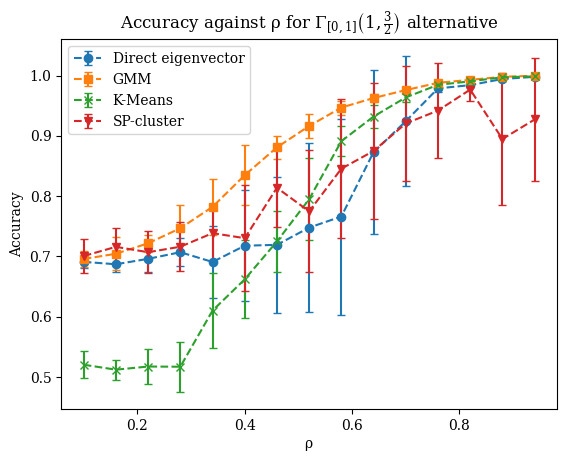

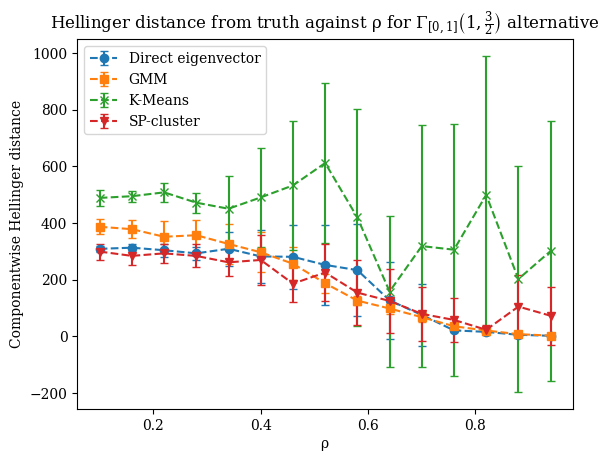

In [38]:
with open("RES_GAMMA_VARYING_RHO.pkl", "rb") as f:
    RES_GAMMA_VARYING_RHO=pickle.load(f)
    
vals = np.arange(0.1, 1, 0.9/15)
a = 1
"""mu_1s = []
for j,b in enumerate(tqdm(vals)): 
    gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [a,0,1/b])
    model = sampling.WSBM(f"$\\Gamma[{a},{b}]$", gamma_dists, gamma_params, np.array([pi,1 - pi]))
    mu_1s.append(np.mean(sampling.truncated_sample(scipy.stats.gamma, [a,0,1/b], 1, 1_000_000)))"""
acc_mean, acc_std, hell_mean, hell_std = RES_GAMMA_VARYING_RHO

for i in range(len(ALGORITHMS)):
    stds = acc_std[:, i]
    yerr = [stds, stds]

    plt.errorbar(vals, acc_mean[:, i], yerr=yerr, capsize=3, fmt="--" + symbols[i], label=ALGORITHMS[i][1])
plt.legend()
plt.xlabel("$\\rho$")
plt.ylabel("Accuracy")
plt.title("Accuracy against $\\rho$ for $\\Gamma_{[0,1]}\\left(1,\\frac{3}{2}\\right)$ alternative")
#plt.show()
plt.savefig("rhoacc.svg")
plt.show()

for i in range(len(ALGORITHMS)):
    stds = hell_std[:, i]
    yerr = [stds, stds]

    plt.errorbar(vals, hell_mean[:, i], yerr=yerr, capsize=3, fmt="--" + symbols[i], label=ALGORITHMS[i][1])
plt.legend()
plt.xlabel("$\\rho$")
plt.ylabel("Componentwise Hellinger distance")
plt.title("Hellinger distance from truth against $\\rho$ for $\\Gamma_{[0,1]}\\left(1,\\frac{3}{2}\\right)$ alternative")
#plt.show()
plt.savefig("rhohell.svg")


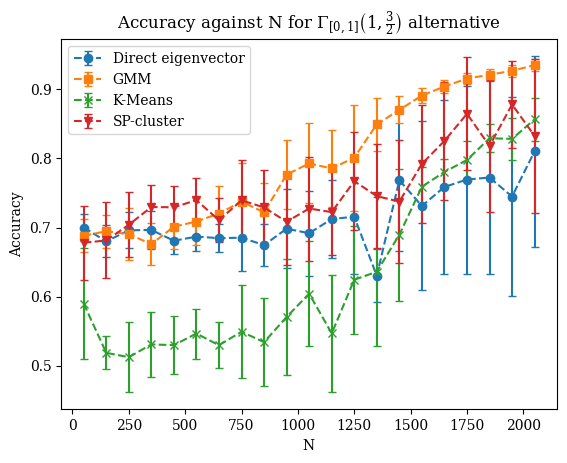

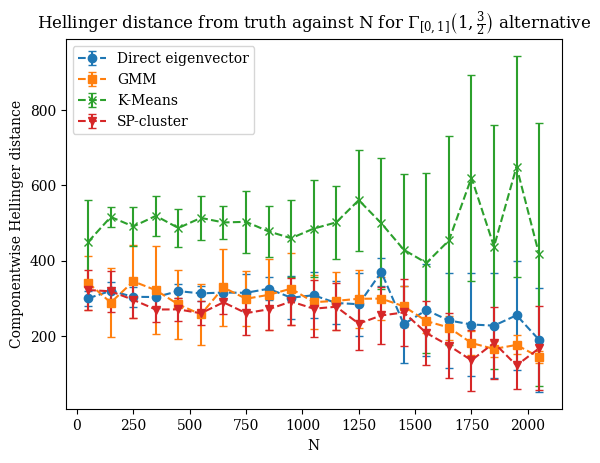

In [177]:
with open("RES_GAMMA_VARYING_N.pkl", "rb") as f:
    RES_GAMMA_VARYING_N=pickle.load(f)
    
vals = range(50, 2100, 100)
a = 1
"""mu_1s = []
for j,b in enumerate(tqdm(vals)): 
    gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [a,0,1/b])
    model = sampling.WSBM(f"$\\Gamma[{a},{b}]$", gamma_dists, gamma_params, np.array([pi,1 - pi]))
    mu_1s.append(np.mean(sampling.truncated_sample(scipy.stats.gamma, [a,0,1/b], 1, 1_000_000)))"""
acc_mean, acc_std, hell_mean, hell_std = RES_GAMMA_VARYING_N

for i in range(len(ALGORITHMS)):
    stds = acc_std[:, i]
    yerr = [stds, stds]

    plt.errorbar(vals, acc_mean[:, i], yerr=yerr, capsize=3, fmt="--" + symbols[i], label=ALGORITHMS[i][1])
plt.legend()
plt.xlabel("$N$")
plt.ylabel("Accuracy")
plt.title("Accuracy against $N$ for $\\Gamma_{[0,1]}\\left(1,\\frac{3}{2}\\right)$ alternative")
#plt.show()
plt.savefig("Nacc.svg")
plt.show()

for i in range(len(ALGORITHMS)):
    stds = hell_std[:, i]
    yerr = [stds, stds]

    plt.errorbar(vals, hell_mean[:, i], yerr=yerr, capsize=3, fmt="--" + symbols[i], label=ALGORITHMS[i][1])
plt.legend()
plt.xlabel("$N$")
plt.ylabel("Componentwise Hellinger distance")
plt.title("Hellinger distance from truth against $N$ for $\\Gamma_{[0,1]}\\left(1,\\frac{3}{2}\\right)$ alternative")
#plt.show()
plt.savefig("Nhell.svg")


In [34]:
symbols = ['o','s','x','v']

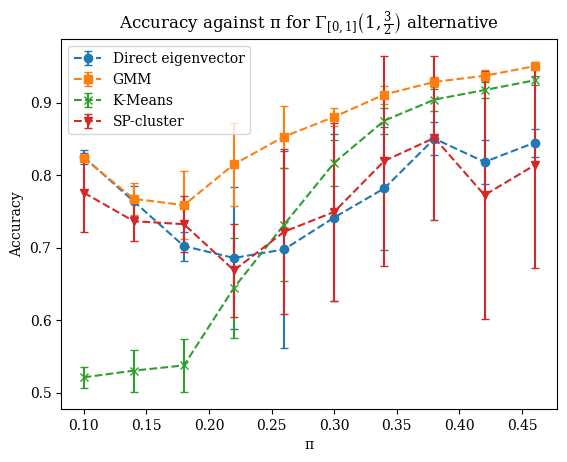

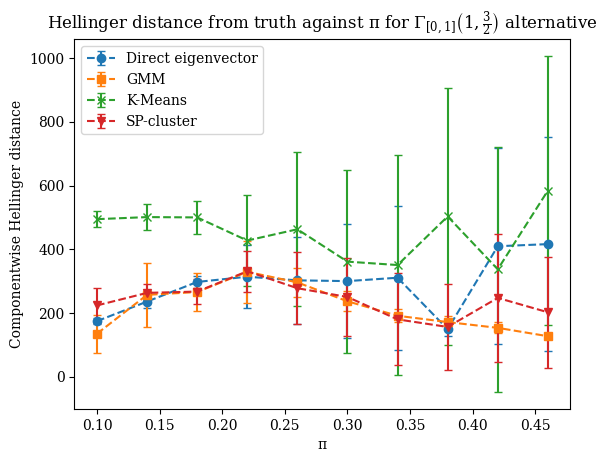

In [178]:
with open("RES_GAMMA_VARYING_PI.pkl", "rb") as f:
    RES_GAMMA_VARYING_PI=pickle.load(f)
    
vals = np.arange(0.1, 0.5, 0.4/10)
a = 1
"""mu_1s = []
for j,b in enumerate(tqdm(vals)): 
    gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [a,0,1/b])
    model = sampling.WSBM(f"$\\Gamma[{a},{b}]$", gamma_dists, gamma_params, np.array([pi,1 - pi]))
    mu_1s.append(np.mean(sampling.truncated_sample(scipy.stats.gamma, [a,0,1/b], 1, 1_000_000)))"""
acc_mean, acc_std, hell_mean, hell_std = RES_GAMMA_VARYING_PI

for i in range(len(ALGORITHMS)):
    stds = acc_std[:, i]
    yerr = [stds, stds]

    plt.errorbar(vals, acc_mean[:, i], yerr=yerr, capsize=3, fmt="--" + symbols[i], label=ALGORITHMS[i][1])
plt.legend()
plt.xlabel("$\\pi$")
plt.ylabel("Accuracy")
plt.title("Accuracy against $\\pi$ for $\\Gamma_{[0,1]}\\left(1,\\frac{3}{2}\\right)$ alternative")
#plt.show()
plt.savefig("piacc.svg")
plt.show()

for i in range(len(ALGORITHMS)):
    stds = hell_std[:, i]
    yerr = [stds, stds]

    plt.errorbar(vals, hell_mean[:, i], yerr=yerr, capsize=3, fmt="--" + symbols[i], label=ALGORITHMS[i][1])
plt.legend()
plt.xlabel("$\\pi$")
plt.ylabel("Componentwise Hellinger distance")
plt.title("Hellinger distance from truth against $\\pi$ for $\\Gamma_{[0,1]}\\left(1,\\frac{3}{2}\\right)$ alternative")
#plt.show()
plt.savefig("pihell.svg")


In [132]:
def compute_raw_CI(a, b, N, rho, pi):
    gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [a,0,1/b])
    model = sampling.WSBM(f"$\\Gamma[{a},{b}]$", gamma_dists, gamma_params, np.array([pi,1 - pi]))

    samples = [[0,0],[0,0]]
    for i in range(2):
        for j in range(2):
            samples[i][j] = sampling.truncated_sample(gamma_dists[i][j], gamma_params[i][j], rho, 1_000_000)
    samples=np.array(samples)
    CI = chernoff.wsbm_CI_(pi, samples, lambda x : x)
    return N * CI

with open("RES_GAMMA_VARYING_PI.pkl", "rb") as f:
    RES_GAMMA_VARYING_PI=pickle.load(f)
with open("RES_GAMMA_VARYING_RHO.pkl", "rb") as f:
    RES_GAMMA_VARYING_RHO=pickle.load(f)
with open("RES_GAMMA_VARYING_N.pkl", "rb") as f:
    RES_GAMMA_VARYING_N=pickle.load(f)
with open("RES_GAMMA_VARYING_MEAN.pkl", "rb") as f:
    RES_GAMMA_VARYING_MEAN=pickle.load(f)

pi_acc_mean, pi_acc_std, pi_hell_mean, pi_hell_std = RES_GAMMA_VARYING_PI
rho_acc_mean, rho_acc_std, rho_hell_mean, rho_hell_std = RES_GAMMA_VARYING_RHO
N_acc_mean, N_acc_std, N_hell_mean, N_hell_std = RES_GAMMA_VARYING_N
b_acc_mean, b_acc_std, b_hell_mean, b_hell_std = RES_GAMMA_VARYING_MEAN

b_vals = np.arange(0.1, 2.6, 2.5/20)
rho_vals = np.arange(0.1, 1, 0.9/15)
N_vals = range(50, 2100, 100)
pi_vals = np.arange(0.1, 0.5, 0.4/10)
a = 1

total_obs = len(pi_acc_mean) + len(rho_acc_mean) + len(b_acc_mean)
xvals = np.zeros(total_obs)
accvals = np.zeros((total_obs,4))
accstds = np.zeros((total_obs,4))
hellvals = np.zeros((total_obs,4))
hellstds = np.zeros((total_obs,4))

for i,b in enumerate(tqdm(b_vals)):
    o = 0
    xvals[i+o] = compute_raw_CI(1, b, 1000, 1, 0.2)
    accvals[i+o],accstds[i+o],hellvals[i+o],hellstds[i+o] = b_acc_mean[i],b_acc_std[i], b_hell_mean[i], b_hell_std[i] 
for i,pi in enumerate(tqdm(pi_vals)):
    o = len(b_acc_mean)
    xvals[i+o] = compute_raw_CI(1, 1.5, 1000, 0.5, pi)
    accvals[i+o],accstds[i+o],hellvals[i+o],hellstds[i+o] = pi_acc_mean[i],pi_acc_std[i], pi_hell_mean[i], pi_hell_std[i]
for i,rho in enumerate(tqdm(rho_vals)):
    o = len(b_acc_mean) + len(pi_acc_mean)
    xvals[i+o] = compute_raw_CI(1, 1.5, 1000, rho, 0.2)
    accvals[i+o],accstds[i+o],hellvals[i+o],hellstds[i+o] = rho_acc_mean[i],rho_acc_std[i], rho_hell_mean[i], rho_hell_std[i]
#for i,N in enumerate(tqdm(N_vals)):
#    o = len(b_acc_mean) + len(pi_acc_mean) + len(rho_acc_mean)
#    xvals[i+o] = compute_raw_CI(1, 2, N, 0.5, 0.2)
#    accvals[i+o],accstds[i+o],hellvals[i+o],hellstds[i+o] = N_acc_mean[i],N_acc_std[i], N_hell_mean[i], N_hell_std[i]

100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


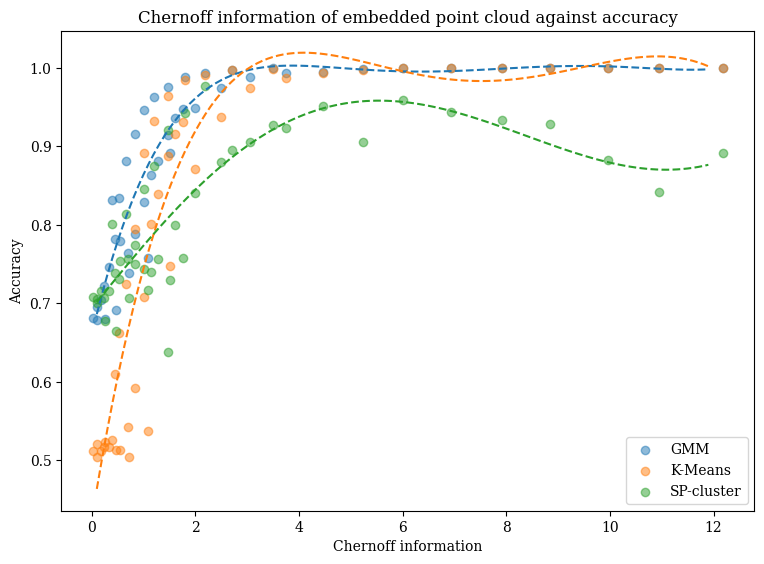

In [168]:
#plt.scatter(xvals[len(b_acc_mean):len(b_acc_mean)+ len(pi_acc_mean)], accvals[:,0][len(b_acc_mean):len(b_acc_mean)+ len(pi_acc_mean)])
from scipy.interpolate import CubicSpline,UnivariateSpline

si = np.argsort(xvals)
fig,ax = plt.subplots(figsize=(8,6))
for i in range(1,4):
    cs = UnivariateSpline(xvals[si], accvals[si,i],k=5,s=0.5)
    x_range = np.arange(0.1, 12, 0.1)
    plt.plot(x_range, cs(x_range), '--')
    plt.scatter(xvals, accvals[:,i], alpha=0.5, label=ALGORITHMS[i][1])
#plt.ylim((-5, 700))
#plt.xlim((0, 5))
plt.xlabel("Chernoff information")
plt.ylabel("Accuracy")
plt.title("Chernoff information of embedded point cloud against accuracy")
plt.tight_layout(pad=2)
plt.legend()
#plt.show()
plt.savefig("ciacc.svg")

In [ ]:

"""mu_1s = []
for j,b in enumerate(tqdm(vals)): 
    gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [a,0,1/b])
    model = sampling.WSBM(f"$\\Gamma[{a},{b}]$", gamma_dists, gamma_params, np.array([pi,1 - pi]))
    mu_1s.append(np.mean(sampling.truncated_sample(scipy.stats.gamma, [a,0,1/b], 1, 1_000_000)))"""
acc_mean, acc_std, hell_mean, hell_std = RES_GAMMA_VARYING_PI

for i in range(len(ALGORITHMS)):
    stds = acc_std[:, i]
    yerr = [stds, stds]

    plt.errorbar(vals, acc_mean[:, i], yerr=yerr, capsize=3, fmt="--" + symbols[i], label=ALGORITHMS[i][1])
plt.legend()
plt.xlabel("$\\pi$")
plt.ylabel("Accuracy")
plt.title("Accuracy against $\\pi$ for $\\Gamma_{[0,1]}\\left(1,\\frac{3}{2}\\right)$ alternative")
#plt.show()
plt.savefig("piacc.svg")
plt.show()

for i in range(len(ALGORITHMS)):
    stds = hell_std[:, i]
    yerr = [stds, stds]

    plt.errorbar(vals, hell_mean[:, i], yerr=yerr, capsize=3, fmt="--" + symbols[i], label=ALGORITHMS[i][1])
plt.legend()
plt.xlabel("$\\pi$")
plt.ylabel("Componentwise Hellinger distance")
plt.title("Hellinger distance from truth against $\\pi$ for $\\Gamma_{[0,1]}\\left(1,\\frac{3}{2}\\right)$ alternative")
#plt.show()
plt.savefig("pihell.svg")
